Purpose
-------
    Assess biogeochemical fields from ACCESS-OM2-WOMBATlite 
    
    We use monthly climatologies for assessment (not specific years)
    
    The fields we are assessing are:
        - Surface nutrients (NO3, dFe)          --> World Ocean Atlas 2023 and Huang et al. 2022 Frontiers in Marine Science
        - Oxygen at 250 metres                  --> World Ocean Atlas 2023 and GOBAI-O2 (Sharp et al 2023 Earth System Science Data)
        - Depth of the oxygen minimum           --> World Ocean Atlas 2023 and GOBAI-O2 (Sharp et al 2023 Earth System Science Data)
        - Depth of the nitracline               --> World Ocean Atlas 2023
        - Surface Chlorophyll & POC             --> Copernicus Marine Service (CMEMS) neural network (Sauzede et al. 2016 JGR: Oceans)
        - Depth integrated Chlorophyll & POC    --> Copernicus Marine Service (CMEMS) neural network (Sauzede et al. 2016 JGR: Oceans)
        - Depth of max Chlorophyll and POC      --> Copernicus Marine Service (CMEMS) neural network (Sauzede et al. 2016 JGR: Oceans)
        - Net Primary Production                --> Carbon-based productivity model (CbPM) 
        - Primary nutrient limitation (N or Fe) --> Browning & Moore 2023 Nature Communications
        - Zooplankton specific grazing rate     --> Rohr et al (in prep)
        - Max annual chlorophyll during bloom   --> Nicholson et al., 2024

    For WOMBAT-midd
        - Nano- to Micro-phytoplankton ratio                --> Kostadinov et al. 2010
        - Depth-integrated nitrogen fixation rate           --> Shao et al., 2024
        - POC flux rate                                     --> Mouw et al., 2016
        


## imports

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import xarray as xr
import scipy as sci
import h5py as h5

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from cmocean.tools import lighten

# regridding package
import xesmf as xe

# statistics package
import skill_metrics as sm


# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("xarray version =", xr.__version__)
print("scipy version =", sci.__version__)
print("h5py version =", h5.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("xesmf version =", xe.__version__)


wrkdir = "/g/data/es60/pjb581/liteexps"
os.chdir(wrkdir)


python version = 3.10.
numpy version = 1.26.4
pandas version = 2.2.1
xarray version = 2023.6.0
scipy version = 1.12.0
h5py version = 3.9.0
matplotlib version = 3.8.0
cmocean version = v3.0.3
cartopy version = 0.22.0
xesmf version = 0.8.5


In [2]:
import warnings
warnings.filterwarnings('ignore')

# start up a dask client

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45221,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:44855,Total threads: 1
Dashboard: /proxy/44241/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:46875,


## choose regular grid coordinates for all regridding and model-data comparision

In [4]:
ds_out = xe.util.grid_global(1,1)

lon_reg = ds_out.coords['lon']
lat_reg = ds_out.coords['lat']



## import nutrient observations

In [5]:

os.chdir(wrkdir)

# WOA 2023 Nitrate
nan_woa = xr.open_dataset("../../observations/woa23_all_n00_01.nc", decode_times=False)['n_an'].squeeze()
n01_woa = xr.open_dataset("../../observations/woa23_all_n01_01.nc", decode_times=False)['n_an'].squeeze()
n02_woa = xr.open_dataset("../../observations/woa23_all_n02_01.nc", decode_times=False)['n_an'].squeeze()
n03_woa = xr.open_dataset("../../observations/woa23_all_n03_01.nc", decode_times=False)['n_an'].squeeze()
n04_woa = xr.open_dataset("../../observations/woa23_all_n04_01.nc", decode_times=False)['n_an'].squeeze()
n05_woa = xr.open_dataset("../../observations/woa23_all_n05_01.nc", decode_times=False)['n_an'].squeeze()
n06_woa = xr.open_dataset("../../observations/woa23_all_n06_01.nc", decode_times=False)['n_an'].squeeze()
n07_woa = xr.open_dataset("../../observations/woa23_all_n07_01.nc", decode_times=False)['n_an'].squeeze()
n08_woa = xr.open_dataset("../../observations/woa23_all_n08_01.nc", decode_times=False)['n_an'].squeeze()
n09_woa = xr.open_dataset("../../observations/woa23_all_n09_01.nc", decode_times=False)['n_an'].squeeze()
n10_woa = xr.open_dataset("../../observations/woa23_all_n10_01.nc", decode_times=False)['n_an'].squeeze()
n11_woa = xr.open_dataset("../../observations/woa23_all_n11_01.nc", decode_times=False)['n_an'].squeeze()
n12_woa = xr.open_dataset("../../observations/woa23_all_n12_01.nc", decode_times=False)['n_an'].squeeze()

lon_woa = xr.open_dataset("../../observations/woa23_all_n00_01.nc", decode_times=False)['n_an'].coords['lon']
lat_woa = xr.open_dataset("../../observations/woa23_all_n00_01.nc", decode_times=False)['n_an'].coords['lat']
dep_woa = xr.open_dataset("../../observations/woa23_all_n00_01.nc", decode_times=False)['n_an'].coords['depth']

# Dissolved Iron (Huang, Y.,Tagliabue, A., & Cassar, N. (2022). Data-driven modeling of dissolved iron in the global ocean. Frontier in Marine Science))
dfe_Huang = xr.open_dataset("../../observations/Monthly_dFe.nc")['dFe_RF']
dfe_Huang = dfe_Huang.isel(Month=slice(0,12)).rename({"Month":"month", "Depth":"depth"})
lon_Huang = dfe_Huang.coords['Longitude']
lat_Huang = dfe_Huang.coords['Latitude']



## create WOA climatologies

In [6]:

no3_woa = xr.concat([n01_woa, n02_woa, n03_woa, n04_woa, n05_woa, n06_woa, n07_woa, n08_woa, n09_woa, n10_woa, n11_woa, n12_woa], dim="month")
nan_woa = xr.concat([nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa, nan_woa], dim="month")
no3_woa = no3_woa.rename({"time":"month"}).assign_coords({"month": np.arange(1,13,1)})
nan_woa = nan_woa.rename({"time":"month"}).assign_coords({"month": np.arange(1,13,1)})
no3_woa = xr.concat([no3_woa, nan_woa.isel(depth=slice(43,102))], dim='depth')

del n01_woa, n02_woa, n03_woa, n04_woa, n05_woa, n06_woa, n07_woa, n08_woa, n09_woa, n10_woa, n11_woa, n12_woa, nan_woa


## regrid the WOA data

In [7]:
lon_woa, lat_woa = np.meshgrid(lon_woa, lat_woa)

ds_in = xr.Dataset(
    {'no3_woa': ( ('month', 'y', 'x'), no3_woa.isel(depth=0).values),
     },
    coords={"lon": (['y','x'], lon_woa),
            "lat": (['y','x'], lat_woa),
            "month": (['month'], no3_woa.coords['month'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
no3_woa_reg = regridder(ds_in['no3_woa'])


### regrid the Huang data
lon_Huang, lat_Huang = np.meshgrid(lon_Huang, lat_Huang)

ds_in = xr.Dataset(
    {'dfe_Huang': ( ('month', 'y', 'x'), dfe_Huang.isel(depth=0).values),
     },
    coords={"lon": (['y','x'], lon_Huang),
            "lat": (['y','x'], lat_Huang),
            "month": (['month'], dfe_Huang.coords['month'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
dfe_Huang_reg = regridder(ds_in['dfe_Huang'])


## get the Copernicus 3D POC and Chlorophyll dataset

In [8]:

chl01_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_01_P20210906.nc", decode_times=True)['chl']
chl02_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_02_P20210906.nc", decode_times=True)['chl']
chl03_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_03_P20210906.nc", decode_times=True)['chl']
chl04_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_04_P20210906.nc", decode_times=True)['chl']
chl05_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_05_P20210906.nc", decode_times=True)['chl']
chl06_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_06_P20210906.nc", decode_times=True)['chl']
chl07_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_07_P20210906.nc", decode_times=True)['chl']
chl08_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_08_P20210906.nc", decode_times=True)['chl']
chl09_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_09_P20210906.nc", decode_times=True)['chl']
chl10_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_10_P20210906.nc", decode_times=True)['chl']
chl11_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_11_P20210906.nc", decode_times=True)['chl']
chl12_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_12_P20210906.nc", decode_times=True)['chl']

chl_cop = xr.concat([chl01_cop, chl02_cop, chl03_cop, chl04_cop, chl05_cop, chl06_cop, chl07_cop, chl08_cop, chl09_cop, chl10_cop, chl11_cop, chl12_cop], dim="time")
chl_cop = chl_cop.rename({"time":"month"})

del chl01_cop, chl02_cop, chl03_cop, chl04_cop, chl05_cop, chl06_cop, chl07_cop, chl08_cop, chl09_cop, chl10_cop, chl11_cop, chl12_cop

### grid coordinate information and depth thicknesses
lon_cop = chl_cop.coords['longitude']
lat_cop = chl_cop.coords['latitude']
dep_cop = chl_cop.coords['depth']

### get surface values and vertically integrated values
surchl_cop = chl_cop.isel(depth=0)

### get the depth maximum of Chl
chmaxz_cop = xr.open_dataset("../../observations/cmems_obs_glo_bgc3d_rep_clim_pomchlmax.nc", decode_times=True)['CHMAXZ'].rename({"LONGITUDE":"longitude", "LATITUDE":"latitude", "TIME":"time"})


## regrid the CMEMS-FFNN (Copernicus) Chlorophyll and POC data

In [9]:

ds_out = xe.util.grid_global(1,1)

### observations
lon_cop, lat_cop = np.meshgrid(lon_cop, lat_cop)
ds_in = xr.Dataset(
    {'surchl_cop': ( ('month', 'y', 'x'), surchl_cop.values),
     'chmaxz_cop': ( ('month', 'y', 'x'), chmaxz_cop.values),
     },
    coords={"lon": (['y','x'], lon_cop),
            "lat": (['y','x'], lat_cop),
            "month": (['month'], surchl_cop.coords['month'].values),
            }
    )

regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')

surchl_cop_reg = regridder(ds_in['surchl_cop'])
chmaxz_cop_reg = regridder(ds_in['chmaxz_cop'])

### make all zero values equal to NaNs
chmaxz_cop_reg = chmaxz_cop_reg.where(chmaxz_cop_reg != 0.0)

### delete the large datasets from memory
del chl_cop, surchl_cop, chmaxz_cop

## Get the Copernicus Carbon dataset and regrid

In [10]:

co201_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850115T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co202_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850215T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co203_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850315T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co204_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850415T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co205_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850515T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co206_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850615T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co207_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850715T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co208_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850815T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co209_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19850915T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co210_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19851015T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co211_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19851115T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']
co212_cop = xr.open_dataset("../../observations/copernicus_carbon_obsprod/dataset-carbon-rep-monthly_19851215T0000Z_P20230821T1545Z.nc", decode_times=True)['fgco2']

co2_cop = xr.concat([co201_cop, co202_cop, co203_cop, co204_cop, co205_cop, co206_cop, co207_cop, co208_cop, co209_cop, co210_cop, co211_cop, co212_cop], dim="time")
co2_cop = co2_cop.rename({"time":"month"})
del co201_cop, co202_cop, co203_cop, co204_cop, co205_cop, co206_cop, co207_cop, co208_cop, co209_cop, co210_cop, co211_cop, co212_cop

co2_cop
lon_co2 = co2_cop.coords['longitude']
lat_co2 = co2_cop.coords['latitude']


In [11]:

ds_out = xe.util.grid_global(1,1)

### observations
lon_co2, lat_co2 = np.meshgrid(lon_co2, lat_co2)
ds_in = xr.Dataset(
    {'fgco2_cop': ( ('month', 'y', 'x'), co2_cop.values),
     },
    coords={"lon": (['y','x'], lon_co2),
            "lat": (['y','x'], lat_co2),
            "month": (['month'], co2_cop.coords['month'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
fgco2_cop_reg = regridder(ds_in['fgco2_cop'])

### delete the large datasets from memory
del co2_cop



## get some accessory satellite datasets (MODIS-based) and horizontally regrid these

In [12]:
with h5.File('../../observations/MODIS_Chl.mat', 'r') as file:
    modis_lon = np.array(file['Lon'])
    modis_lat = np.array(file['Lat'])
    modis_tim = np.array(file['time_steps'])
print("Got Chl")
with h5.File('../../observations/MODIS_Carbon_NPP.mat', 'r') as file:
    modis_npp = np.array(file['NPP'])
print("Got NPP")


ds_in = xr.Dataset(
    {'modis_npp': ( ('day', 'y', 'x'), modis_npp.transpose((2,1,0))),
     },
    coords={"lon": (['y','x'], modis_lon.transpose((1,0))),
            "lat": (['y','x'], modis_lat.transpose((1,0))),
            "day": (['day'], modis_tim[:,0]),
            }
    )

print("Regridding")
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')

modis_npp_reg = regridder(ds_in['modis_npp'])


### delete the large datasets from memory
del modis_npp


Got Chl
Got NPP
Regridding


## regrid the MODIS-based datasets in time to a monthly resolution for comparison with the model output

In [13]:
from datetime import datetime, timedelta

# 1. create new datetime array with dates of MODIS climatology
days_of_year = modis_tim[:,0]
year = 2005
start_date = datetime(year, 1, 1)
mons = [(start_date + timedelta(days=int(day)-1)).month for day in days_of_year]
days = [(start_date + timedelta(days=int(day)-1)).day for day in days_of_year]
year = np.ones(len(days))*2005
dates = pd.DataFrame({'year':year.astype(int), 'month':mons, 'day':days})
daycoordinate = pd.to_datetime(dates)

# 2. apply new dates to modis xarray coordinate
modis_npp_reg = modis_npp_reg.assign_coords({'day':daycoordinate.values})

# 3. set the monthly center points
month_points = pd.date_range(start=datetime(2005, 1, 1), periods=12, freq='MS') + pd.offsets.Day(14)

# 4. interpolate the data to the monthly center points and rename time coordinate
modis_npp_reg = modis_npp_reg.interp(day=month_points, method='linear').rename({'day':'month'})


## retrieve the non-gridded datsets and extract the data ready for comparison with the model

### requires some looping and binning of data into model grid boxes

#### Primary limiting nutrient

In [14]:
limitations = pd.read_excel("../../observations/Browning_Moore_Bioassay_Dataset_v1.0.xlsx", skiprows=0, usecols=(2,3,24,25,26))
limitations.columns = ['Lon', 'Lat', 'Primary', 'Secondary', 'Tertiary']
limitations = limitations.drop(limitations.index[0])

### print out the unique kinds of primary limitations
print(limitations['Primary'].unique())

### drop Manganese and NaNs
limitations = limitations[limitations['Primary'] != 'Mn']
limitations = limitations.dropna(subset=['Primary'])

# N = 1
# P = 2
# Fe = 3
# Si = 4
limitations.loc[limitations['Primary'] == 'N', 'Primary'] = 2.0
limitations.loc[limitations['Primary'] == 'N_P', 'Primary'] = 1.5
limitations.loc[limitations['Primary'] == 'P', 'Primary'] = 1.0
limitations.loc[limitations['Primary'] == 'Fe', 'Primary'] = 3.0
limitations.loc[limitations['Primary'] == 'Fe_Mn', 'Primary'] = 3.0
limitations.loc[limitations['Primary'] == 'Fe_Co', 'Primary'] = 3.0
limitations.loc[limitations['Primary'] == 'Fe_Zn_sep', 'Primary'] = 3.0
limitations.loc[limitations['Primary'] == 'N_Fe', 'Primary'] = 2.5
limitations.loc[limitations['Primary'] == 'N_Fe_sep', 'Primary'] = 2.5

### print out the unique kinds of primary limitations
print(limitations['Primary'].unique())



['N' 'Fe' 'N_Fe' nan 'N_P' 'Mn' 'Fe_Mn' 'Fe_Zn_sep' 'Fe_Co' 'N_Fe_sep']
[2.0 3.0 2.5 1.5]


#### Particle fluxes

In [15]:

pocflux = pd.read_table("../../observations/Mouw_2016_particle_fluxes/GO_flux.tab", skiprows=87, usecols=(1,3,4,8,9,11,15,16,17,18,40))
pocflux.columns = ['Location ID', 'Latitude', 'Longitude', 'Depth (m)', 'Datetime deployed', 'Duration (days)', 'C flux [mg/m**2/day]', 'C flux std dev', 'POC flux [mg/m**2/day]', 'POC flux std dev', 'Reference']
print("Number of unique locations with POC flux data =", len(pocflux['Location ID'].unique()))

### First, find the mean month of sampling by averaging the start and end month 
pocflux['Month_start'] = pocflux['Datetime deployed'].str[5:7].astype(float)
pocflux['Month_end'] = pocflux['Month_start'] + pocflux['Duration (days)'] / 30.0
pocflux['Month'] = (pocflux['Month_start'] + pocflux['Month_end'] ) *0.5
print(pocflux['Month_start'].min(), pocflux['Month_start'].max())
print(pocflux['Month_end'].min(), pocflux['Month_end'].max())
print(pocflux['Month'].min(), pocflux['Month'].max())

### if the average month carries over into the next year, remove 12 to account for this
pocflux.loc[pocflux['Month'] >= 12.5, 'Month'] += -12
print(pocflux['Month'].min(), pocflux['Month'].max())

# Bin the months into 13 different numerical (integer) categories representing all months (1-12) and an annual average (0)
pocflux['Month'] = pd.cut(pocflux['Month'], bins = [0.49, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 1e5]).cat.codes + 1
print(pocflux['Month'].min(), pocflux['Month'].max())
print(pocflux.loc[pocflux['Month']==0,['Datetime deployed', 'Duration (days)']])
pocflux.loc[pocflux['Month']==13, 'Month'] = 0
print(pocflux['Month'].min(), pocflux['Month'].max())

# Now find the average measured POC fluxes and the locations and months of sampling. We can therefore have multiple months of sampling at the same location.
pocflux_ave = pocflux.groupby(['Month', 'Location ID'])['POC flux [mg/m**2/day]'].mean()
pocflux_std = pocflux.groupby(['Month', 'Location ID'])['POC flux [mg/m**2/day]'].std()
pocflux_lon = pocflux.groupby(['Month', 'Location ID'])['Longitude'].mean()
pocflux_lat = pocflux.groupby(['Month', 'Location ID'])['Latitude'].mean()
pocflux_dep = pocflux.groupby(['Month', 'Location ID'])['Depth (m)'].mean()
pocflux_mon = pocflux.groupby(['Month', 'Location ID'])['Month'].mean()
pocflux_std_measured = pocflux.groupby(['Month', 'Location ID'])['POC flux std dev'].mean()



Number of unique locations with POC flux data = 674
1.0 12.0
1.0 150.76666666666668
1.0 79.88333333333334
0.5 67.88333333333334
0 13
     Datetime deployed  Duration (days)
7676               NaN            6.185
7687               NaN           10.994
7690               NaN           10.869
7736               NaN            3.771
7774               NaN           22.562
7827               NaN            2.653
7828               NaN            2.653
7829               NaN            2.653
0 12


#### Put the Limiting nutrient, poc fluxes and nitrogen fixation rates onto the model grid for comparison

In [16]:
print("binning primary limiting nutrient")
limits_reg = np.zeros((180,360))*np.nan
for xi,xx in enumerate(lon_reg[0,:].values):
    for yi,yy in enumerate(lat_reg[:,0].values):
        limxs = (limitations['Lon'] >= xx-0.5) & (limitations['Lon'] < xx+0.5)
        limys = (limitations['Lat'] >= yy-0.5) & (limitations['Lat'] < yy+0.5)
        if np.any(limxs*limys):
            tmp = limitations[limxs*limys]
            limits_reg[yi,xi] = tmp['Primary'].mean()
        else:
            continue

limits_reg = xr.DataArray(limits_reg, dims=('lat', 'lon'))
print("Number of limiting nutrient measurements before binning?", limitations['Primary'].count())
print("Number of limiting nutrient measurements after binning?", limits_reg.count().values)


print("binning particle flux dataset")

# get the vertical grid information since this dataset is in 3D (4D in time)
vgrid  = xr.open_dataset("../wombat_files/ocean_vgrid.nc").rename({"zeta":"z", "nzv":"z"})
dep = vgrid['z'][1:-1:2]
dep_b = vgrid['z'][0::2]
dep_thick = dep_b[1::]-dep_b[0:-1]

cc = 0
pocflux_reg = np.zeros((13,50,180,360))*np.nan
for xi,xx in enumerate(lon_reg.values[0,:]):
    limxs = (pocflux_lon >= xx-0.5) & (pocflux_lon < xx+0.5)
    if np.any(limxs) == False:
        continue
    else:
        tmp1_ave = pocflux_ave[limxs]
        tmp1_lat = pocflux_lat[limxs]
        tmp1_dep = pocflux_dep[limxs]
        tmp1_mon = pocflux_mon[limxs]
    
    for yi,yy in enumerate(lat_reg.values[:,0]):
        limys = (tmp1_lat >= yy-0.5) & (tmp1_lat < yy+0.5)
        if np.any(limys) == False:
            continue
        else:
            tmp2_ave = tmp1_ave[limys]
            tmp2_dep = tmp1_dep[limys]
            tmp2_mon = tmp1_mon[limys]
        
        for zi,zz in enumerate(dep.values):
            limzs = (tmp2_dep >= dep_b.values[zi]) & (tmp2_dep < dep_b.values[zi+1])
            if np.any(limzs) == False:
                continue
            else:
                tmp3_ave = tmp2_ave[limzs]
                tmp3_mon = tmp2_mon[limzs]
                
            for mm in np.arange(0,13,1):
                limms = tmp3_mon.astype(int) == mm
                if np.any(limms) == False:
                    continue
                else:
                    tmp4_ave = tmp3_ave[limms]
                    pocflux_reg[mm,zi,yi,xi] = tmp4_ave.mean()
                    #print("Found a POC flux measurement at", mm,xi,yi,zi, "with %i values"%(tmp4_ave.count()))
                    cc += 1

pocflux_reg = xr.DataArray(pocflux_reg, dims=('month', 'depth', 'lat', 'lon'))
print("Number of POC flux measurements before binning?", pocflux_ave.count())
print("Number of POC flux measurements after binning?", pocflux_reg.count().values)


binning primary limiting nutrient
Number of limiting nutrient measurements before binning? 942
Number of limiting nutrient measurements after binning? 137
binning particle flux dataset
Number of POC flux measurements before binning? 2399
Number of POC flux measurements after binning? 1986


### save the measured POC flux to an excel file for later extraction

In [17]:
pocflux_new = pd.DataFrame({'Lon':pocflux_lon.values,
                            'Lat':pocflux_lat.values,
                            'Dep':pocflux_dep.values,
                            'Mon':pocflux_mon.values,
                            'flux_mean':pocflux_ave.values,
                            'flux_std':pocflux_std.values,
                            })

pocflux_new.to_excel("../../observations/pocflux_Mouw2016.xlsx")

## Now, load the model output to compare with the observations

In [18]:
os.getcwd()

'/g/data/es60/pjb581/liteexps'

In [21]:

var = ['surno3', 'surfer', 'surchl', 'chmaxz', 'intnpp', 'fgco2', 'phylim', 'pocsink']

out = {}
poc = np.zeros((21,50,2503))
for v in var:
    out[v] = np.zeros((21,12,300,360))
    
for i in np.arange(1,22,1):
    if i%1 == 0:
        print(i)
    fs = './lite2output_optim_1-20_100years/outputexp_100year_%i'%(i) + ".nc"
    out[var[0]][i-1,:,:,:] = np.log10(xr.open_dataset(fs)['SURNO3'].squeeze())
    out[var[1]][i-1,:,:,:] = xr.open_dataset(fs)['SURFER'].squeeze()
    out[var[2]][i-1,:,:,:] = xr.open_dataset(fs)['SURCHL'].squeeze()
    out[var[3]][i-1,:,:,:] = xr.open_dataset(fs)['CHMAXZ'].squeeze()
    out[var[4]][i-1,:,:,:] = xr.open_dataset(fs)['INTNPP'].squeeze()
    out[var[5]][i-1,:,:,:] = xr.open_dataset(fs)['FGCO2'].squeeze()
    out[var[6]][i-1,:,:,:] = xr.open_dataset(fs)['PHY_LIM'].squeeze()
    fs = './lite2output_optim_1-20_100years/outputexp_100year_%i_pocsink.nc'%(i)
    poc[i-1,:,:] = xr.open_dataset(fs)['POCSINK_XYT'].squeeze()



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [22]:
print("average out the month coordinate for the nutrient limitation dataset")
out[var[6]][out[var[6]]==0.0] = np.nan
out[var[6]] = np.nanmean(out[var[6]], axis=1)


average out the month coordinate for the nutrient limitation dataset


### remove the depth component of the POCsink dataset to make direct comparisons

In [23]:
print("we use the pocflux_Mouw2016.txt data created earlier")

poc_flux = np.zeros((21,len(pocflux_new)))*np.nan
print(np.shape(poc_flux))

zeta = xr.open_dataset('ocean_vgrid.nc')['zeta'].squeeze()
dep_mod = zeta.isel(nzv=slice(1,101,2))
top_mod = zeta.isel(nzv=slice(0,100,2))
bot_mod = zeta.isel(nzv=slice(2,101,2))

print("to subsample the model output at the right depth levels")
for exp in np.arange(21):
    print(exp)
    for ii in np.arange(0,len(poc[exp,0,:])):
        tmppoc = poc[exp,:,ii]
        tmpdep = pocflux_new['Dep'].iloc[ii]
        tmpind = (top_mod < tmpdep) & (bot_mod > tmpdep)
        if np.any(tmpind):
            poc_flux[exp,ii] = tmppoc[tmpind]
        else:
            poc_flux[exp,ii] = np.nan

del poc    


we use the pocflux_Mouw2016.txt data created earlier
(21, 2503)
to subsample the model output at the right depth levels
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


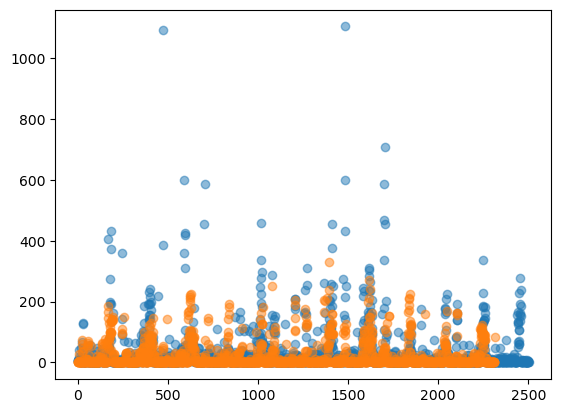

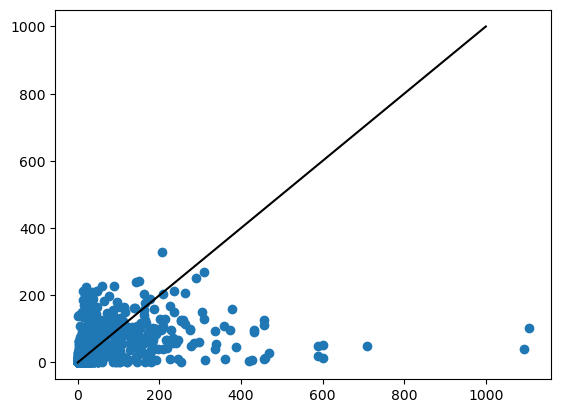

In [24]:
exp = 20
plt.figure()
plt.scatter(np.arange(len(pocflux_new['flux_mean'])),pocflux_new['flux_mean'], alpha=0.5)
plt.scatter(np.arange(len(poc_flux[exp,:])),poc_flux[exp,:], alpha=0.5)

plt.figure()
plt.scatter(pocflux_new['flux_mean'], poc_flux[exp,:])
plt.plot((0,1000),(0,1000), 'k-')


## Regrid the model output to the common regular grid

In [25]:
lon_mod = xr.open_dataset('./lite2output_optim_1-20_100years/outputexp_100year_1.nc').coords['XT_OCEAN']
lat_mod = xr.open_dataset('./lite2output_optim_1-20_100years/outputexp_100year_1.nc').coords['YT_OCEAN']

lon_mod, lat_mod = np.meshgrid(lon_mod, lat_mod)

### model
ds_in = xr.Dataset(
    {var[0]+"_le1": ( ('month', 'y', 'x'), out[var[0]][0,:,:,:]),
     var[1]+"_le1": ( ('month', 'y', 'x'), out[var[1]][0,:,:,:]),
     var[2]+"_le1": ( ('month', 'y', 'x'), out[var[2]][0,:,:,:]),
     var[3]+"_le1": ( ('month', 'y', 'x'), out[var[3]][0,:,:,:]),
     var[4]+"_le1": ( ('month', 'y', 'x'), out[var[4]][0,:,:,:]),
     var[5]+"_le1": ( ('month', 'y', 'x'), out[var[5]][0,:,:,:]),
     var[6]+"_le1": ( ('y', 'x'), out[var[6]][0,:,:]),
     },
    coords={"lon": (['y','x'], lon_mod),
            "lat": (['y','x'], lat_mod),
            "month": (['month'], no3_woa.coords['month'].values),
            }
    )

ds_in


<xarray.Dataset>
Dimensions:     (month: 12, y: 300, x: 360)
Coordinates:
    lon         (y, x) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
    lat         (y, x) float64 -77.88 -77.88 -77.88 -77.88 ... 89.77 89.77 89.77
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: y, x
Data variables:
    surno3_le1  (month, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    surfer_le1  (month, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    surchl_le1  (month, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    chmaxz_le1  (month, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    intnpp_le1  (month, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    fgco2_le1   (month, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    phylim_le1  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [26]:
print("Applying dimensions to new xarray dataset of model output")
dimensions = ('month', 'y', 'x')
for exp in np.arange(1,22,1):
    if exp%1 == 0:
        print(exp)
    for vv in var:
        if (vv == var[6]):
            ds_in[vv+'_le%i'%(exp)] = (('y','x'), out[vv][exp-1,:,:])
        else:
            ds_in[vv+'_le%i'%(exp)] = (dimensions, out[vv][exp-1,:,:,:])

ds_in

Applying dimensions to new xarray dataset of model output
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


<xarray.Dataset>
Dimensions:       (month: 12, y: 300, x: 360)
Coordinates:
    lon           (y, x) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
    lat           (y, x) float64 -77.88 -77.88 -77.88 ... 89.77 89.77 89.77
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: y, x
Data variables: (12/168)
    surno3_le1    (month, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    surfer_le1    (month, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    surchl_le1    (month, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    chmaxz_le1    (month, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    intnpp_le1    (month, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    fgco2_le1     (month, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    ...            ...
    surchl_le21   (month, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    chmaxz_le21   (month, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    intnpp_le21   (month, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    fgco2_le21    (month, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    phylim_le21   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    pocsink_le21  (month, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [27]:
print("Regridding new xarray dataset of model output")
regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
ds_mod_reg = {}
for exp in np.arange(1,22,1):
    if exp%1 == 0:
        print(exp)
    for vv in var:
        ds_mod_reg[vv+'_le%i'%(exp)] = regridder(ds_in[vv+'_le%i'%(exp)])



Regridding new xarray dataset of model output
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


## Assess the model fit to the observations

In [28]:
var

['surno3',
 'surfer',
 'surchl',
 'chmaxz',
 'intnpp',
 'fgco2',
 'phylim',
 'pocsink']

In [29]:
print("put all the observations into a dictionary for iteration")
obsdata = {
    'surno3': np.log10(no3_woa_reg.where(no3_woa_reg>0.0001, other=0.0001)),
    'surfer': dfe_Huang_reg,
    'surchl': surchl_cop_reg,
    'chmaxz': chmaxz_cop_reg,
    'intnpp': modis_npp_reg,
    'fgco2' : fgco2_cop_reg,
    'phylim': limits_reg.rename({"lat":"y", "lon":"x"}),
    'pocsink': pocflux_new['flux_mean'],
    }


put all the observations into a dictionary for iteration


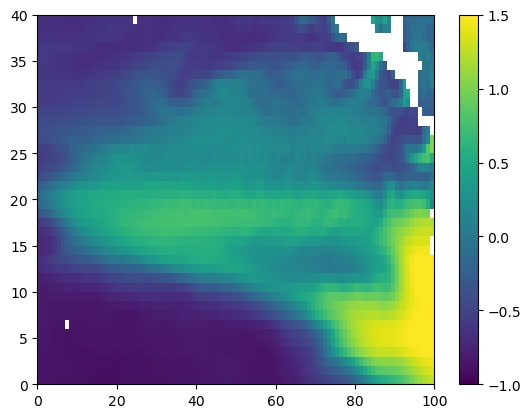

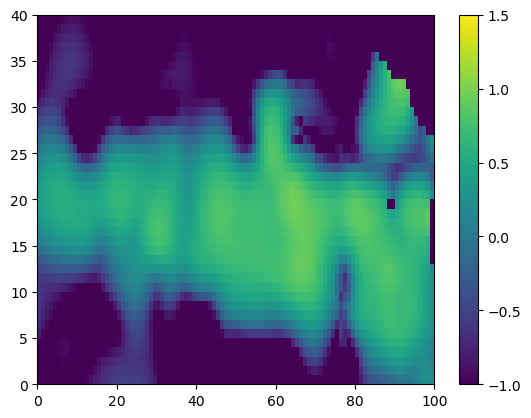

In [30]:
plt.figure()
plt.pcolormesh(ds_mod_reg[var[0]+'_le21'].isel(y=slice(70,110), x=slice(0,100), month=1), vmin=-1, vmax=1.5)
plt.colorbar()

plt.figure()
plt.pcolormesh(obsdata[var[0]].isel(y=slice(70,110), x=slice(0,100), month=1), vmin=-1, vmax=1.5)
plt.colorbar()

In [31]:

print("create the dictionary for holding the statistics (global, Southern Ocean and Equatorial band)")
stats = {}
stats_so = {}
stats_eq = {}

exp = 1
for vv in var:
    # flatten the datasets into 1D
    if vv == var[-1]:
        predicted = poc_flux[exp-1,:].ravel()
        observed = obsdata[vv].ravel()
        predicted_so = np.array([0.0])
        observed_so = np.array([0.0])
        predicted_eq = np.array([0.0])
        observed_eq = np.array([0.0])
    else:
        predicted = ds_mod_reg[vv+'_le%i'%(exp)].data.ravel()
        observed = obsdata[vv].data.ravel()
        predicted_so = ds_mod_reg[vv+'_le%i'%(exp)].isel(y=slice(0,60)).data.ravel()
        observed_so = obsdata[vv].isel(y=slice(0,60)).data.ravel()
        predicted_eq = ds_mod_reg[vv+'_le%i'%(exp)].isel(y=slice(70,110), x=slice(0,100)).data.ravel()
        observed_eq = obsdata[vv].isel(y=slice(70,110), x=slice(0,100)).data.ravel()

    # remove NaNs
    pred_good = ~np.isnan(predicted)
    obs_good = ~np.isnan(observed)
    good = pred_good * obs_good
    predicted = predicted[good]
    observed = observed[good]
    if np.std(predicted) == 0.0:
        predicted[-1] = predicted[-1]+1e-10

    pred_good = ~np.isnan(predicted_so)
    obs_good = ~np.isnan(observed_so)
    good = pred_good * obs_good
    predicted_so = predicted_so[good]
    observed_so = observed_so[good]
    if np.std(predicted_so) == 0.0:
        predicted_so[-1] = predicted_so[-1]+1e-10

    pred_good = ~np.isnan(predicted_eq)
    obs_good = ~np.isnan(observed_eq)
    good = pred_good * obs_good
    predicted_eq = predicted_eq[good]
    observed_eq = observed_eq[good]
    if np.std(predicted_eq) == 0.0:
        predicted_eq[-1] = predicted_eq[-1]+1e-10

    # print number of shared good points for comparison. 
    #  Counts for predicted == observed
    #print(np.count_nonzero(pred_good), np.count_nonzero(obs_good), np.count_nonzero(good))
    stats[vv+'_sdev'] = sm.taylor_statistics(predicted, observed)['sdev']
    stats[vv+'_nsdev'] = (sm.taylor_statistics(predicted, observed)['sdev']/sm.taylor_statistics(predicted, observed)['sdev'][0]).tolist()
    stats[vv+'_crmsd'] = sm.taylor_statistics(predicted, observed)['crmsd']
    stats[vv+'_rmse'] = np.array([0.0, sm.rmsd(predicted, observed)]).tolist()
    stats[vv+'_nrmse'] = np.array([0.0, sm.rmsd((predicted - np.mean(predicted))/np.std(predicted), (observed - np.mean(observed))/np.std(observed))]).tolist()
    stats[vv+'_ccoef'] = sm.taylor_statistics(predicted, observed)['ccoef'].tolist()
    stats[vv+'_bias'] = np.array([0.0, np.mean(predicted - observed)]).tolist()
    
    stats_so[vv+'_sdev'] = sm.taylor_statistics(predicted_so, observed_so)['sdev']
    stats_so[vv+'_nsdev'] = (sm.taylor_statistics(predicted_so, observed_so)['sdev']/sm.taylor_statistics(predicted_so, observed_so)['sdev'][0]).tolist()
    stats_so[vv+'_crmsd'] = sm.taylor_statistics(predicted_so, observed_so)['crmsd']
    stats_so[vv+'_rmse'] = np.array([0.0, sm.rmsd(predicted_so, observed_so)]).tolist()
    stats_so[vv+'_nrmse'] = np.array([0.0, sm.rmsd((predicted_so - np.mean(predicted_so))/np.std(predicted_so), (observed_so - np.mean(observed_so))/np.std(observed_so))]).tolist()
    stats_so[vv+'_ccoef'] = sm.taylor_statistics(predicted_so, observed_so)['ccoef'].tolist()
    stats_so[vv+'_bias'] = np.array([0.0, np.mean(predicted_so - observed_so)]).tolist()

    stats_eq[vv+'_sdev'] = sm.taylor_statistics(predicted_eq, observed_eq)['sdev']
    stats_eq[vv+'_nsdev'] = (sm.taylor_statistics(predicted_eq, observed_eq)['sdev']/sm.taylor_statistics(predicted_eq, observed_eq)['sdev'][0]).tolist()
    stats_eq[vv+'_crmsd'] = sm.taylor_statistics(predicted_eq, observed_eq)['crmsd']
    stats_eq[vv+'_rmse'] = np.array([0.0, sm.rmsd(predicted_eq, observed_eq)]).tolist()
    stats_eq[vv+'_nrmse'] = np.array([0.0, sm.rmsd((predicted_eq - np.mean(predicted_eq))/np.std(predicted_eq), (observed_eq - np.mean(observed_eq))/np.std(observed_eq))]).tolist()
    stats_eq[vv+'_ccoef'] = sm.taylor_statistics(predicted_eq, observed_eq)['ccoef'].tolist()
    stats_eq[vv+'_bias'] = np.array([0.0, np.mean(predicted_eq - observed_eq)]).tolist()


for exp in np.arange(2,22,1):
    if exp%1 == 0:
        print(exp)
    for vi, vv in enumerate(var):
        # flatten the datasets into 1D
        if vv == var[-1]:
            predicted = poc_flux[exp-1,:].ravel()
            observed = obsdata[vv].ravel()
            predicted_so = np.array([0.0])
            observed_so = np.array([0.0])
            predicted_eq = np.array([0.0])
            observed_eq = np.array([0.0])
        else:
            predicted = ds_mod_reg[vv+'_le%i'%(exp)].data.ravel()
            observed = obsdata[vv].data.ravel()
            predicted_so = ds_mod_reg[vv+'_le%i'%(exp)].isel(y=slice(0,60)).data.ravel()
            observed_so = obsdata[vv].isel(y=slice(0,60)).data.ravel()
            predicted_eq = ds_mod_reg[vv+'_le%i'%(exp)].isel(y=slice(70,110), x=slice(0,100)).data.ravel()
            observed_eq = obsdata[vv].isel(y=slice(70,110), x=slice(0,100)).data.ravel()
        
        
        # remove NaNs
        pred_good = ~np.isnan(predicted)
        obs_good = ~np.isnan(observed)
        good = pred_good * obs_good
        predicted = predicted[good]
        observed = observed[good]
        if np.std(predicted) == 0.0:
            predicted[-1] = predicted[-1]+1e-10
        
        pred_good = ~np.isnan(predicted_so)
        obs_good = ~np.isnan(observed_so)
        good = pred_good * obs_good
        predicted_so = predicted_so[good]
        observed_so = observed_so[good]
        if np.std(predicted_so) == 0.0:
            predicted_so[-1] = predicted_so[-1]+1e-10

        pred_good = ~np.isnan(predicted_eq)
        obs_good = ~np.isnan(observed_eq)
        good = pred_good * obs_good
        predicted_eq = predicted_eq[good]
        observed_eq = observed_eq[good]
        if np.std(predicted_eq) == 0.0:
            predicted_eq[-1] = predicted_eq[-1]+1e-10
    
    
        # calculate stats for Taylor Diagrams
        stats[vv+'_sdev'].append(sm.taylor_statistics(predicted, observed)['sdev'][1])
        stats[vv+'_nsdev'].append(sm.taylor_statistics(predicted, observed)['sdev'][1]/sm.taylor_statistics(predicted, observed)['sdev'][0])
        stats[vv+'_crmsd'].append(sm.taylor_statistics(predicted, observed)['crmsd'][1])
        stats[vv+'_ccoef'].append(sm.taylor_statistics(predicted, observed)['ccoef'][1])
        stats[vv+'_bias'].append(np.mean(predicted - observed))
        stats[vv+'_rmse'].append(sm.rmsd(predicted, observed))
        stats[vv+'_nrmse'].append(sm.rmsd((predicted - np.mean(predicted))/np.std(predicted), (observed - np.mean(observed))/np.std(observed)))
        
        stats_so[vv+'_sdev'].append(sm.taylor_statistics(predicted_so, observed_so)['sdev'][1])
        stats_so[vv+'_nsdev'].append(sm.taylor_statistics(predicted_so, observed_so)['sdev'][1]/sm.taylor_statistics(predicted_so, observed_so)['sdev'][0])
        stats_so[vv+'_crmsd'].append(sm.taylor_statistics(predicted_so, observed_so)['crmsd'][1])
        stats_so[vv+'_ccoef'].append(sm.taylor_statistics(predicted_so, observed_so)['ccoef'][1])
        stats_so[vv+'_bias'].append(np.mean(predicted_so - observed_so))
        stats_so[vv+'_rmse'].append(sm.rmsd(predicted_so, observed_so))
        stats_so[vv+'_nrmse'].append(sm.rmsd((predicted_so - np.mean(predicted_so))/np.std(predicted_so), (observed_so - np.mean(observed_so))/np.std(observed_so)))

        stats_eq[vv+'_sdev'].append(sm.taylor_statistics(predicted_eq, observed_eq)['sdev'][1])
        stats_eq[vv+'_nsdev'].append(sm.taylor_statistics(predicted_eq, observed_eq)['sdev'][1]/sm.taylor_statistics(predicted_eq, observed_eq)['sdev'][0])
        stats_eq[vv+'_crmsd'].append(sm.taylor_statistics(predicted_eq, observed_eq)['crmsd'][1])
        stats_eq[vv+'_ccoef'].append(sm.taylor_statistics(predicted_eq, observed_eq)['ccoef'][1])
        stats_eq[vv+'_bias'].append(np.mean(predicted_eq - observed_eq))
        stats_eq[vv+'_rmse'].append(sm.rmsd(predicted_eq, observed_eq))
        stats_eq[vv+'_nrmse'].append(sm.rmsd((predicted_eq - np.mean(predicted_eq))/np.std(predicted_eq), (observed_eq - np.mean(observed_eq))/np.std(observed_eq)))



create the dictionary for holding the statistics (global, Southern Ocean and Equatorial band)
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


## save the statistics

In [32]:
df_stats = pd.DataFrame(stats)
df_stats


,surno3_sdev,surno3_nsdev,surno3_crmsd,surno3_rmse,surno3_nrmse,surno3_ccoef,surno3_bias,surfer_sdev,surfer_nsdev,surfer_crmsd,...,phylim_nrmse,phylim_ccoef,phylim_bias,pocsink_sdev,pocsink_nsdev,pocsink_crmsd,pocsink_rmse,pocsink_nrmse,pocsink_ccoef,pocsink_bias
0,1.430087,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.097068,1.000000,0.000000,...,0.000000,1.000000,0.000000,72.773509,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1,0.917878,0.641834,1.059045,1.118789,0.809055,0.672715,0.360711,0.189935,1.956715,0.194348,...,0.809141,0.672645,-0.273810,38.886276,0.534347,66.414748,67.245568,1.073731,0.423551,-10.537918
2,0.841568,0.588473,1.072850,1.144953,0.817671,0.665707,0.399886,0.185805,1.914173,0.195031,...,0.896763,0.597908,-0.323308,40.330553,0.554193,66.487214,67.255929,1.071230,0.426234,-10.139547
3,0.828596,0.579402,1.066468,1.149298,0.809013,0.672749,0.428406,0.183111,1.886411,0.191902,...,0.860186,0.630040,-0.308897,39.136074,0.537779,65.614509,66.329304,1.055635,0.442818,-9.711477
4,0.953831,0.666974,1.072529,1.103127,0.822813,0.661490,0.258015,0.196259,2.021867,0.192992,...,0.836782,0.649898,-0.285714,38.159287,0.524357,65.938113,66.828739,1.064994,0.432894,-10.874076
5,0.883761,0.617977,1.069441,1.135715,0.817785,0.665614,0.382288,0.188214,1.938982,0.196243,...,0.856282,0.633390,-0.309524,39.637323,0.544667,66.630432,67.474885,1.076314,0.420774,-10.641695
6,0.874744,0.611672,1.077426,1.130964,0.825487,0.659286,0.343850,0.190395,1.961454,0.188644,...,0.897988,0.596809,-0.330827,35.474576,0.487466,65.552332,66.542284,1.060950,0.437193,-11.435352
7,0.914715,0.639621,1.059507,1.113170,0.809380,0.672452,0.341457,0.188788,1.944899,0.199639,...,0.836629,0.650026,-0.298246,39.908933,0.548399,66.139475,66.869283,1.065033,0.432852,-9.852455
8,0.942371,0.658961,1.071228,1.104665,0.821576,0.662506,0.269735,0.182223,1.877265,0.187071,...,0.837827,0.649023,-0.301378,37.906293,0.520880,65.824685,66.640309,1.063011,0.435004,-10.394312
9,0.878697,0.614436,1.059095,1.146923,0.806646,0.674661,0.440172,0.185136,1.907271,0.198450,...,0.776505,0.698520,-0.264411,37.625438,0.517021,65.117143,65.935007,1.047573,0.451295,-10.352917


In [33]:
df_so_stats = pd.DataFrame(stats_so)
df_so_stats


,surno3_sdev,surno3_nsdev,surno3_crmsd,surno3_rmse,surno3_nrmse,surno3_ccoef,surno3_bias,surfer_sdev,surfer_nsdev,surfer_crmsd,...,phylim_nrmse,phylim_ccoef,phylim_bias,pocsink_sdev,pocsink_nsdev,pocsink_crmsd,pocsink_rmse,pocsink_nrmse,pocsink_ccoef,pocsink_bias
0,1.008893,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.047319,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.0,NaN,0.0,0.000000e+00,0.0,NaN,0.000000e+00
1,0.676341,0.670379,0.733626,0.764642,0.791629,0.686662,0.215570,0.175894,3.717205,0.181631,...,0.861617,0.628808,-0.427536,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
2,0.669600,0.663698,0.731630,0.754189,0.788638,0.689025,0.183084,0.189926,4.013751,0.194726,...,0.871818,0.619966,-0.561594,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
3,0.655447,0.649669,0.732412,0.757060,0.788851,0.688857,0.191606,0.180817,3.821247,0.186154,...,0.874204,0.617884,-0.547101,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
4,0.743576,0.737022,0.732478,0.748522,0.788258,0.689325,0.154150,0.171369,3.621577,0.176755,...,0.871860,0.619930,-0.391304,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
5,0.669889,0.663984,0.732009,0.760337,0.789173,0.688603,0.205611,0.186941,3.950677,0.191944,...,0.878955,0.613719,-0.554348,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
6,0.685284,0.679243,0.730676,0.751089,0.787869,0.689631,0.173916,0.164131,3.468626,0.169298,...,0.890689,0.603337,-0.528986,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
7,0.695104,0.688976,0.734016,0.757883,0.792382,0.686066,0.188698,0.198428,4.193418,0.203249,...,0.749020,0.719485,-0.525362,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
8,0.726298,0.719896,0.732428,0.750001,0.789375,0.688443,0.161401,0.173714,3.671143,0.178754,...,0.857606,0.632256,-0.518116,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
9,0.658724,0.652918,0.736364,0.767394,0.794603,0.684303,0.216014,0.190921,4.034784,0.196725,...,0.765341,0.707127,-0.496377,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10


In [34]:
df_eq_stats = pd.DataFrame(stats_eq)
df_eq_stats


,surno3_sdev,surno3_nsdev,surno3_crmsd,surno3_rmse,surno3_nrmse,surno3_ccoef,surno3_bias,surfer_sdev,surfer_nsdev,surfer_crmsd,...,phylim_nrmse,phylim_ccoef,phylim_bias,pocsink_sdev,pocsink_nsdev,pocsink_crmsd,pocsink_rmse,pocsink_nrmse,pocsink_ccoef,pocsink_bias
0,1.067783,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.053454,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.0,NaN,0.0,0.000000e+00,0.0,NaN,0.000000e+00
1,0.671750,0.629107,0.927395,0.928070,0.990148,0.509803,0.035382,0.030681,0.573964,0.070438,...,1.058798,0.439473,-0.451389,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
2,0.554375,0.519184,0.956661,0.957960,1.049183,0.449607,0.049873,0.026062,0.487562,0.066699,...,1.118713,0.374241,-0.520833,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
3,0.603652,0.565332,0.898277,0.925903,0.957936,0.541180,0.224491,0.034123,0.638365,0.074824,...,1.046426,0.452497,-0.444444,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
4,0.587233,0.549955,0.991454,1.014402,1.095160,0.400313,-0.214545,0.023700,0.443378,0.062219,...,1.119025,0.373892,-0.534722,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
5,0.591912,0.554337,0.967771,0.968246,1.059981,0.438220,-0.030326,0.025538,0.477750,0.065650,...,1.116811,0.376367,-0.513889,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
6,0.463930,0.434479,0.994995,1.007116,1.123578,0.368787,-0.155780,0.020611,0.385581,0.059889,...,1.200279,0.279665,-0.638889,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
7,0.680383,0.637192,0.914565,0.918180,0.971974,0.527633,0.081395,0.033574,0.628091,0.073564,...,1.058798,0.439473,-0.451389,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
8,0.586908,0.549651,0.991544,1.009367,1.095364,0.400088,-0.188844,0.022672,0.424149,0.062284,...,1.118713,0.374241,-0.520833,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10
9,0.739826,0.692861,0.863857,0.997981,0.899165,0.595751,0.499718,0.061089,1.142835,0.097138,...,0.829471,0.655989,-0.256944,0.0,NaN,0.0,1.000000e-10,NaN,NaN,1.000000e-10


In [35]:
print("Saving the global skill")

cols_to_drop = [column for column in df_stats.columns if '_rmse' not in column]
df_rmse = df_stats.drop(columns=cols_to_drop).drop(0)
df_rmse['sum_rmse'] = df_rmse.sum(axis=1)
df_rmse.to_excel('lite2optim_100years_output_RMSE.xlsx', index=False)

cols_to_drop = [column for column in df_stats.columns if '_nrmse' not in column]
df_nrmse = df_stats.drop(columns=cols_to_drop).drop(0)
df_nrmse['sum_nrmse'] = df_nrmse.sum(axis=1)
df_nrmse.to_excel('lite2optim_100years_output_NRMSE.xlsx', index=False)

cols_to_drop = [column for column in df_stats.columns if '_sdev' not in column]
df_sdev = df_stats.drop(columns=cols_to_drop).drop(0)
df_sdev['sum_sdev'] = df_sdev.sum(axis=1)
df_sdev.to_excel('lite2optim_100years_output_SDEV.xlsx', index=False)

cols_to_drop = [column for column in df_stats.columns if '_nsdev' not in column]
df_nsdev = df_stats.drop(columns=cols_to_drop).drop(0)
df_nsdev['sum_nsdev'] = df_nsdev.sum(axis=1)
df_nsdev.to_excel('lite2optim_100years_output_NSDEV.xlsx', index=False)

cols_to_drop = [column for column in df_stats.columns if '_bias' not in column]
df_bias = df_stats.drop(columns=cols_to_drop).drop(0)
df_bias['sum_bias'] = df_bias.sum(axis=1)
df_bias.to_excel('lite2optim_100years_output_BIAS.xlsx', index=False)

cols_to_drop = [column for column in df_stats.columns if '_ccoef' not in column]
df_ccoef = df_stats.drop(columns=cols_to_drop).drop(0)
df_ccoef['sum_ccoef'] = df_ccoef.sum(axis=1)
df_ccoef.to_excel('lite2optim_100years_output_CCOEF.xlsx', index=False)


print("Saving the Southern Ocean skill")

cols_to_drop = [column for column in df_so_stats.columns if '_rmse' not in column]
df_so_rmse = df_so_stats.drop(columns=cols_to_drop).drop(0)
df_so_rmse['sum_rmse'] = df_so_rmse.sum(axis=1)
df_so_rmse.to_excel('lite2optim_100years_output_so_RMSE.xlsx', index=False)

cols_to_drop = [column for column in df_so_stats.columns if '_nrmse' not in column]
df_so_nrmse = df_so_stats.drop(columns=cols_to_drop).drop(0)
df_so_nrmse['sum_nrmse'] = df_so_nrmse.sum(axis=1)
df_so_nrmse.to_excel('lite2optim_100years_output_so_NRMSE.xlsx', index=False)

cols_to_drop = [column for column in df_so_stats.columns if '_sdev' not in column]
df_so_sdev = df_so_stats.drop(columns=cols_to_drop).drop(0)
df_so_sdev['sum_sdev'] = df_so_sdev.sum(axis=1)
df_so_sdev.to_excel('lite2optim_100years_output_so_SDEV.xlsx', index=False)

cols_to_drop = [column for column in df_so_stats.columns if '_nsdev' not in column]
df_so_nsdev = df_so_stats.drop(columns=cols_to_drop).drop(0)
df_so_nsdev['sum_nsdev'] = df_so_nsdev.sum(axis=1)
df_so_nsdev.to_excel('lite2optim_100years_output_so_NSDEV.xlsx', index=False)

cols_to_drop = [column for column in df_so_stats.columns if '_bias' not in column]
df_so_bias = df_so_stats.drop(columns=cols_to_drop).drop(0)
df_so_bias['sum_bias'] = df_so_bias.sum(axis=1)
df_so_bias.to_excel('lite2optim_100years_output_so_BIAS.xlsx', index=False)

cols_to_drop = [column for column in df_so_stats.columns if '_ccoef' not in column]
df_so_ccoef = df_so_stats.drop(columns=cols_to_drop).drop(0)
df_so_ccoef['sum_ccoef'] = df_so_ccoef.sum(axis=1)
df_so_ccoef.to_excel('lite2optim_100years_output_so_CCOEF.xlsx', index=False)


print("Saving the Equatorial band skill")

cols_to_drop = [column for column in df_eq_stats.columns if '_rmse' not in column]
df_eq_rmse = df_eq_stats.drop(columns=cols_to_drop).drop(0)
df_eq_rmse['sum_rmse'] = df_eq_rmse.sum(axis=1)
df_eq_rmse.to_excel('lite2optim_100years_output_eq_RMSE.xlsx', index=False)

cols_to_drop = [column for column in df_eq_stats.columns if '_nrmse' not in column]
df_eq_nrmse = df_eq_stats.drop(columns=cols_to_drop).drop(0)
df_eq_nrmse['sum_nrmse'] = df_eq_nrmse.sum(axis=1)
df_eq_nrmse.to_excel('lite2optim_100years_output_eq_NRMSE.xlsx', index=False)

cols_to_drop = [column for column in df_eq_stats.columns if '_sdev' not in column]
df_eq_sdev = df_eq_stats.drop(columns=cols_to_drop).drop(0)
df_eq_sdev['sum_sdev'] = df_eq_sdev.sum(axis=1)
df_eq_sdev.to_excel('lite2optim_100years_output_eq_SDEV.xlsx', index=False)

cols_to_drop = [column for column in df_eq_stats.columns if '_nsdev' not in column]
df_eq_nsdev = df_eq_stats.drop(columns=cols_to_drop).drop(0)
df_eq_nsdev['sum_nsdev'] = df_eq_nsdev.sum(axis=1)
df_eq_nsdev.to_excel('lite2optim_100years_output_eq_NSDEV.xlsx', index=False)

cols_to_drop = [column for column in df_eq_stats.columns if '_bias' not in column]
df_eq_bias = df_eq_stats.drop(columns=cols_to_drop).drop(0)
df_eq_bias['sum_bias'] = df_eq_bias.sum(axis=1)
df_eq_bias.to_excel('lite2optim_100years_output_eq_BIAS.xlsx', index=False)

cols_to_drop = [column for column in df_eq_stats.columns if '_ccoef' not in column]
df_eq_ccoef = df_eq_stats.drop(columns=cols_to_drop).drop(0)
df_eq_ccoef['sum_ccoef'] = df_eq_ccoef.sum(axis=1)
df_eq_ccoef.to_excel('lite2optim_100years_output_eq_CCOEF.xlsx', index=False)


Saving the global skill
Saving the Southern Ocean skill
Saving the Equatorial band skill
